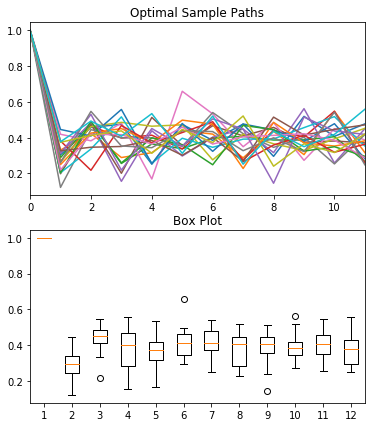

In [1]:
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt

α = 0.25
β = 0.90
T = 10
M = 20             # number of sample paths

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.random.lognormal(0,0.25,shock_size)


def ForwardPass(c_star):
    consumption=lambda xvals,ygrid: np.interp(xvals,grid,ygrid)
    s=np.ones(T+2)
    s[0]=1
    psi = np.random.lognormal(0,0.1,T+1)
    for t in np.arange(T+1):
        if consumption(s[t],c_star[t]) < psi[t]*s[t]**α:
            s[t+1]=psi[t]*s[t]**α-consumption(s[t],c_star[t])
        else:
            s[t+1]= 0  
    return s    
    
    
# Approximate Backward Recursion    

c_star=np.zeros([T+1,grid_size])
v_star=np.zeros([T+1,grid_size])
v_func = lambda x,y: np.interp(x, grid, y)

for t in np.arange(T,-1,-1):
    
    if t==T:
        for i,s in enumerate(grid):
            objective = lambda c: -c*(5-c)
            c_star[-1,i]=fminbound(objective,0,s)
            v_star[-1,i]=-objective(c_star[-1,i])
    else:
        for i,s in enumerate(grid):
            
            objective = lambda c: -c*(5-c)-β*np.mean(v_func(shocks*(s**α)-c,v_star[t+1,:]))
            c_star[t,i]=fminbound(objective,0,s)
            v_star[t,i]=-objective(c_star[-1,i])


# Simulation of optimal paths

SamplePaths=np.zeros([M,T+2])
for i in range(M):
    SamplePaths[i,:]=ForwardPass(c_star)
    
fig,ax = plt.subplots(2,1,figsize=(6,7))

for i in range(M):
    ax[0].plot(SamplePaths[i])
ax[0].set_xlim([0,T+1])
ax[0].set_title("Optimal Sample Paths")

ax[1].boxplot(SamplePaths)
ax[1].set_title("Box Plot")
plt.show()